In [304]:
from tqdm.notebook import tqdm
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as op3 
import pandas as pd
import time
from scipy.sparse.csgraph import connected_components
from open3d import JVisualizer
from BfTableGenerator import RansacCollector
from matplotlib import cm
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view
from DDBSCAN import Raster_DBSCAN
from scipy import ndimage 
import cv2
theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]
theta = np.sort(theta_raw)
azimuths = np.arange(0,360,0.2)

In [305]:
os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest')
frame_set = np.arange(0,5000,1).astype('int')
collector = RansacCollector(pcap_path=r'./2020-7-27-10-30-0.pcap',frames_set = frame_set)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1,inuse_frame = frame_set)
# d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1 FrameSampling


  0%|          | 2/5000 [00:00<04:45, 17.52it/s]

Loading pcap...


  0%|          | 0/32 [00:00<?, ?it/s]

Generating Threshold Map


100%|██████████| 32/32 [00:17<00:00,  1.87it/s]


In [690]:
Thred_map = collector.thred_map
db = Raster_DBSCAN(window_size=(9,9),eps = 2, min_samples= 20,Td_map_szie=Thred_map.shape)

In [691]:
Td_maps = []
Labeling_maps = []
Time_consumings = []
for i in tqdm(range(1000)):
    ti = time.time()
    Td_map = collector.td_maps[i].copy()
    Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Td_maps.append(Td_map)
    Labeling_maps.append(Labeling_map)
    Time_consumings.append((time.time() - ti)*1000)

In [611]:
def get_tracking_points(Label_map,sparse_template):
    """
    Get sparsed tracking points as input implement the KL algorithm 
    
    
    """
    Label_map_sparesed = Label_map.copy()
    Label_map_sparesed[sparse_template] = 0
    tracking_points = np.array(np.where(Label_map_sparesed != 0)).T.reshape((-1,1,2))  
    represented_labels = Label_map_sparesed[tracking_points[:,:,0],tracking_points[:,:,1]]
    tracking_points = tracking_points.astype(np.float32)
    tracking_points = tracking_points[:,:,[1,0]]
    
    return tracking_points,represented_labels

def read_Td_map(ind,Label_map,width_fringe):
    
    Td_map_cur = Td_maps[ind].copy()
    Td_map_cur[Label_map == 0] = 0
    Td_map_cur = (255*Td_map_cur/300).astype(np.uint8)
    Td_map_cur_padded = np.concatenate([Td_map_cur[:,-width_fringe:],
                                                    Td_map_cur,
                                                    Td_map_cur[:,:width_fringe]],axis = 1)
    return Td_map_cur,Td_map_cur_padded
def read_Label_map(ind,width_fringe):
    """
    Read Frame, the labels are started from 1, 0 refers to noise
    Lavel_map_cur or next size is padded to 32 x (1800 + 2 x int(win_size))
    Considering the roll over margin
    """
    Label_map_cur = Labeling_maps[ind].copy()
    Label_map_cur += 1
    Label_map_cur_padded = np.concatenate([Label_map_cur[:,-width_fringe:],
                                                Label_map_cur,
                                                Label_map_cur[:,:width_fringe]],axis = 1)
    return Label_map_cur,Label_map_cur_padded

In [612]:
def read_Td_map(ind,Label_map,width_fringe):
    
    Td_map_cur = Td_maps[ind].copy()
    Td_map_cur[Label_map == 0] = 0
    Td_map_cur = (255*Td_map_cur/300).astype(np.uint8)
    Td_map_cur_padded = np.concatenate([Td_map_cur[:,-width_fringe:],
                                                    Td_map_cur,
                                                    Td_map_cur[:,:width_fringe]],axis = 1)
    return Td_map_cur,Td_map_cur_padded

In [613]:
def read_Label_map(ind,width_fringe):
    """
    Read Frame, the labels are started from 1, 0 refers to noise
    Lavel_map_cur or next size is padded to 32 x (1800 + 2 x int(win_size))
    Considering the roll over margin
    """
    Label_map_cur = Labeling_maps[ind].copy()
    Label_map_cur += 1
    Label_map_cur_padded = np.concatenate([Label_map_cur[:,-width_fringe:],
                                                Label_map_cur,
                                                Label_map_cur[:,:width_fringe]],axis = 1)
    return Label_map_cur,Label_map_cur_padded

In [914]:
def get_associations(Label_map_next_padded,valid_represented_labels,valid_tracking_points_pred):
    
    associations = np.concatenate(
    [valid_represented_labels.reshape((-1,1)), 
     #valid representative labels at current frame (transmitted to the pred position)
    Label_map_next_padded[valid_tracking_points_pred[:,1].astype(np.int16),valid_tracking_points_pred[:,0].astype(np.int16)].reshape((-1,1))] 
    # overlapped labels at next frame given the transmission
    ,axis = 1)

    #occured associations at next frame, overlapped points counts 
    occured_associations,associations_counts = np.unique(associations,axis = 0,return_counts=True)
    #exclude associations with background at next frame 
    occured_associations,associations_counts = occured_associations[occured_associations[:,1] != 0],associations_counts[occured_associations[:,1] != 0]

    #unique_valid_labels refers to labels in current frame which are overlapped at next frame 
    unique_valid_labels,valid_labels_counts  = np.unique(valid_represented_labels,return_counts=True)
    
    return occured_associations,associations_counts,unique_valid_labels,valid_labels_counts

In [915]:
class detected_object():
    def __init__(self):
        self.global_id = None
        self.represented_label_at_each_frame = None
        self.cur_motion = None
        self.occlusion_indicator = None

In [1039]:
"""
Initial params
"""
window_size_lk = 5
width_fringe = int(window_size_lk/2)
sparse_interval = 3 # this param controls the sparese degree of LK implementation, smaller it is, the Label matrix is sparser
sparse_ind = np.array(np.meshgrid(np.arange(Thred_map.shape[0]),np.arange(0,Thred_map.shape[1] + 2 * width_fringe,sparse_interval))).T.reshape(-1,2)
sparse_template = np.full((Thred_map.shape[0],Thred_map.shape[1] + 2 * width_fringe),False)
sparse_template[sparse_ind[:,0],sparse_ind[:,1]] = True

overlapped_thred = 0.01 # overlapped ratio indicating successfully associated 
lk_params = dict(winSize = (window_size_lk,window_size_lk),
                maxLevel = 2,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03))
cur_frame = 0 #current frame number
global_id = 0
tracking_list = {}
off_track_list = {}
"""
Initialization Code
"""
Label_map_initial,Label_map_initial_padded = read_Label_map(cur_frame,width_fringe)
Td_map_initial,Td_map_initial_padded = read_Td_map(cur_frame,Label_map_initial,width_fringe)

cur_frame += 1
# Generate prerequisites Label maps(padded), Td maps(padded)
Label_map_cur,Label_map_cur_padded = Label_map_initial,Label_map_initial_padded
Td_map_cur,Td_map_cur_padded = Td_map_initial,Td_map_initial_padded
Label_map_next,Label_map_next_padded = read_Label_map(cur_frame,width_fringe)
Td_map_next,Td_map_next_padded = read_Td_map(cur_frame,Label_map_next,width_fringe)

#represented_labels is the labels that tracking points representing at current frame 
tracking_points,represented_labels = get_tracking_points(Label_map_cur_padded,sparse_template) 
"""
Using the tracking points to calculate the optical flow, 
the result represent the entire motion pattern of each cluster 
also, the Td_maps need to be padded in order to issue the roll over problem
the motion estimated result is given in valid_tracking_points_pred,
st is an indicator indicating  which tracking point is successfully tracked 

"""
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points,
                                                       None,**lk_params)
# predicted tracking points 
valid_tracking_points_pred = tracking_points_pred[st == 1]
valid_tracking_points_pred[:,1][valid_tracking_points_pred[:,1] > 31] = 31

# the labels representing each predicted point 
valid_represented_labels = represented_labels[st == 1]
total_represented_labels = np.unique(represented_labels)
occured_associations,associations_counts,unique_valid_labels,valid_labels_counts = get_associations(Label_map_next_padded,
                                                                                                    valid_represented_labels,
                                                                                                    valid_tracking_points_pred)

# iterate all detected objects
for i,cur_id in enumerate(total_represented_labels):
    temp_object = detected_object()
    if cur_id in occured_associations[:,0]: #whether a detected object is associated at next frame  
        tracking_contour_count = valid_labels_counts[np.where(unique_valid_labels == cur_id)[0]] # tracking pounts count of cur_id at current frame
        overlapped_label_next = occured_associations[occured_associations[:,0] == cur_id][:,1] # labels associating to cur_id at next frame
        overlapped_contour_count = associations_counts[occured_associations[:,0] == cur_id] 
        overlapped_ratios = overlapped_contour_count/tracking_contour_count
        if overlapped_ratios.max() > overlapped_thred:
            associated_label_next = overlapped_label_next[overlapped_ratios.argmax()] #associated label at next frame 
            temp_object.global_id = global_id
            temp_object.represented_label_at_each_frame = [cur_id,associated_label_next]
            tracking_list[global_id] = temp_object
    """
    cur_id is not associated with any object at next frame, it has been totally occluded
    else:
    """
    global_id += 1


In [1040]:

"""
Iterative
"""
while cur_frame < 100:
    Label_map_cur,Label_map_cur_padded = Label_map_next,Label_map_next_padded
    Td_map_cur,Td_map_cur_padded = Td_map_next,Td_map_next_padded
    cur_frame += 1
    Label_map_next,Label_map_next_padded = read_Label_map(cur_frame,width_fringe)
    Td_map_next,Td_map_next_padded = read_Td_map(cur_frame,Label_map_next,width_fringe)
    tracking_points,represented_labels = get_tracking_points(Label_map_cur_padded,sparse_template) 
    tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points,
                                                           None,**lk_params)
    # predicted tracking points 
    valid_tracking_points_pred = tracking_points_pred[st == 1]
    valid_tracking_points_pred[:,1][valid_tracking_points_pred[:,1] > 31] = 31
    # the labels representing each predicted point 
    valid_represented_labels = represented_labels[st == 1]
    total_represented_labels = np.unique(represented_labels)

    occured_associations,associations_counts,unique_valid_labels,valid_labels_counts = get_associations(Label_map_next_padded,
                                                                                                        valid_represented_labels,
                                                                                                        valid_tracking_points_pred)
    #represented label at cur frame, global id
    tracking_latest_label = np.array([tracking_list[key].represented_label_at_each_frame[-1] for key in tracking_list.keys()])
    tracking_glbid = np.array([key for key in tracking_list.keys()])


    for i,la in enumerate(tracking_latest_label):
        if la in occured_associations[:,0]: 
             #associated or lose tracking 
            tracking_contour_count = valid_labels_counts[np.where(unique_valid_labels == la)[0]] # tracking pounts count of cur_id at current frame
            overlapped_label_next = occured_associations[occured_associations[:,0] == la][:,1] # labels associating to cur_id at next frame
            overlapped_contour_count = associations_counts[occured_associations[:,0] == la] 
            overlapped_ratios = overlapped_contour_count/tracking_contour_count
            if overlapped_ratios.max() > overlapped_thred:
                associated_label_next = overlapped_label_next[overlapped_ratios.argmax()] #associated label at next frame 
                tracking_list[tracking_glbid[i]].represented_label_at_each_frame.append(associated_label_next)
            else:
                off_track_list[tracking_glbid[i]] = tracking_list.pop(tracking_glbid[i])

        else:
            off_track_list[tracking_glbid[i]] = tracking_list.pop(tracking_glbid[i])

    new_object_labels = [nl for nl in unique_valid_labels if (nl in occured_associations[:,0])&(nl not in tracking_latest_label) ]

    if len(new_object_labels) != 0 :
        for nl in new_object_labels:
            tracking_contour_count = valid_labels_counts[np.where(unique_valid_labels == nl)[0]] # tracking pounts count of cur_id at current frame
            overlapped_label_next = occured_associations[occured_associations[:,0] == nl][:,1] # labels associating to cur_id at next frame
            overlapped_contour_count = associations_counts[occured_associations[:,0] == nl] 
            overlapped_ratios = overlapped_contour_count/tracking_contour_count
            associated_label_next = overlapped_label_next[overlapped_ratios.argmax()] #associated label at next frame 
            if overlapped_ratios.max() > overlapped_thred:
                temp_object.global_id = global_id
                temp_object.represented_label_at_each_frame = [cur_id,associated_label_next]
                tracking_list[global_id] = temp_object
                global_id += 1



In [ ]:
tracking_points_pred,st,err = cv2.calcOpticalFlowPyrLK(Td_map_cur_padded,Td_map_next_padded,tracking_points,
                                                       None,**lk_params)

In [1063]:
cur_label,next_label = 1,2
cur_frame,next_frame = 4,5
Td_map_next,Td_map_next_padded = read_Label_map(next_frame,width_fringe)
Td_map_next,Td_map_next_padded = read_Td_map(next_frame,Label_map_next,width_fringe)
Td_map_cur,Td_map_cur_padded = read_Label_map(cur_frame,width_fringe)
Td_map_cur,Td_map_cur_padded = read_Td_map(cur_frame,Label_map_cur,width_fringe)

In [1075]:
frame = 4
Td_map = Td_maps[frame]
Labeling_map = Labeling_maps[frame]
label = 3
visualize_label(Td_map,Labeling_map,label)

JVisualizer with 1 geometries

In [1073]:
def visualize_label(Td_map,Labeling_map,label):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = []
    for i in range(len(Labels)):
        if Labels[i] == label:
            Colors.append(color_map[0])
        else:
            Colors.append(color_map[-1])
    Colors = np.array(Colors)
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    visualizer = JVisualizer()

    visualizer.add_geometry(pcd)
    visualizer.show()

In [674]:
def visualize(Td_map,Labeling_map):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])


    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = []
    for i in range(len(Labels)):
        Colors.append(color_map[Labels[i]])
    Colors = np.array(Colors)
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    visualizer = JVisualizer()
    visualizer.add_geometry(pcd)
    visualizer.show()

In [683]:
np.random.seed(250)
color_map = np.random.random((100,3))
color_map = np.concatenate([color_map,np.array([[1,1,1]])])

In [ ]:
i = 602
Td_map = collector.td_maps[i].copy()
Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
Thred_map = collector.thred_map
db = Raster_DBSCAN(window_size=(9,9),eps = 2, min_samples= 20,Td_map_szie=Thred_map.shape)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
visualize(Td_map,Labeling_map)

## DBSCAN efficiency test

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
db = DBSCAN(eps=1.5,min_samples=10)


In [27]:
time_consumption = []
for frame_ind in tqdm(range(17000)):
    ti = time.time()
    Td_map = collector.td_maps[frame_ind].copy()
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Labels = db.fit_predict(XYZ)
    time_consumption.append(1000*(time.time() - ti))

KeyboardInterrupt: 

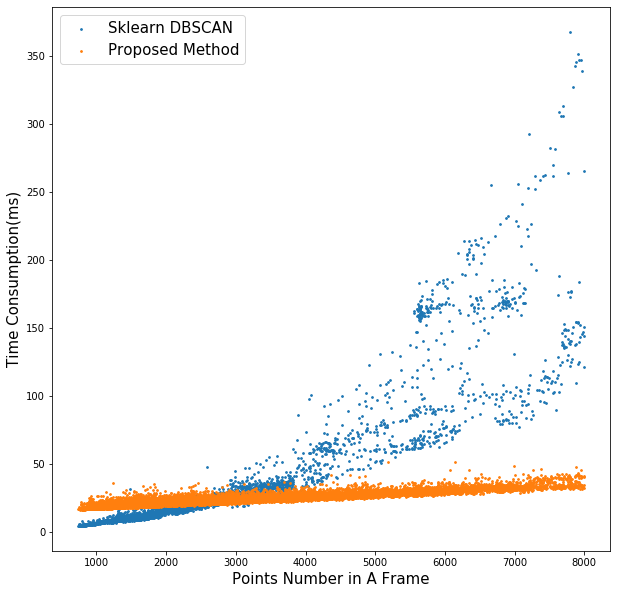

In [46]:
plt.figure(figsize = (10,10))
plt.scatter(points_num_db[points_num_db<8000],time_consumption[points_num_db<8000],s = 3,label = 'Sklearn DBSCAN')
plt.scatter(points_num[points_num < 8000],t_con[points_num < 8000],s = 3,label = 'Proposed Method')
plt.legend(fontsize = 15)
plt.xlabel('Points Number in A Frame',fontsize = 15)
plt.ylabel('Time Consumption(ms)',fontsize = 15)
plt.show()